# Chapter 5 - Applied Exercise Solutions

In [348]:
import numpy as np
import pandas as pd # My code
import statsmodels.api as sm
import statsmodels.formula.api as smf # My code
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.linear_model import LinearRegression # My code
from sklearn.linear_model import LogisticRegression # My code
from sklearn.base import clone
from ISLP.models import sklearn_sm
from ISLP import confusion_table
from sklearn.metrics import accuracy_score # My code
from matplotlib.pyplot import subplots # My code

### 5

In Chapter 4, we used logistic regression to predict the probability of `default` using `income` and `balance` on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

In [3]:
rng = np.random.default_rng(0)
Default = load_data('Default')

**(a)** Fit a logistic regression model that uses `income` and `balance` to predict `default`.

In [32]:
Default['defaultBin'] =  np.where(Default['default'] == 'Yes', 1, 0)

**(b)** Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

i. Split the sample set into a training set and a validation set.

In [37]:
Default_train, Default_valid = train_test_split(Default, test_size=0.5, random_state=0)

ii. Fit a multiple logistic regression model using only the training observations.

In [38]:
model_logistic = smf.glm(formula='default ~ income + balance', data=Default_train, family=sm.families.Binomial())
results_logistic = model_logistic.fit()
summarize(results_logistic) # WRONG because of default encoding

,coef,std err,z,P>|z|
Intercept,11.389600,0.635000,17.935,0.000
income,-0.000016,0.000007,-2.151,0.031
balance,-0.005600,0.000000,-16.792,0.000


In [45]:
# Using statsmodels
model_logistic = smf.glm(formula='defaultBin ~ income + balance', data=Default_train, family=sm.families.Binomial())
results_logistic = model_logistic.fit()
summarize(results_logistic) # CORRECT

,coef,std err,z,P>|z|
Intercept,-11.389600,0.635000,-17.935,0.000
income,0.000016,0.000007,2.151,0.031
balance,0.005600,0.000000,16.792,0.000


In [49]:
# Using sklearn
model_logistic_sk = LogisticRegression(fit_intercept=True)
model_logistic_sk.fit(Default_train[['income','balance']], Default_train['defaultBin'])
model_logistic_sk.coef_
# model_logistic_sk.intercept_ # CORRECT

array([[1.57956908e-05, 5.56457746e-03]])

iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.

iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

In [57]:
# Using statsmodels
logistic_pred = results_logistic.predict(exog=Default_valid)
logistic_labels = np.zeros((Default_valid.shape[0]))
logistic_labels[logistic_pred > 0.5] = 1
confusion_table(logistic_labels, Default_valid['defaultBin'])

Truth,0.0,1.0
Predicted,,
0.0,4801,132
1.0,13,54


In [59]:
accuracy_score(logistic_labels, Default_valid['defaultBin'])

0.971

In [81]:
# Using sklearn
logistic_pred_sk = model_logistic_sk.predict(Default_valid[['income','balance']])
np.allclose(logistic_labels, logistic_pred_sk) # sklearn produces the same label predictions

True

In [80]:
model_logistic_sk.score(Default_valid[['income','balance']],Default_valid['defaultBin'] ) # sklearn produces same accuracy score

0.971

**(c)** Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

In [86]:
Default_train, Default_valid = train_test_split(Default, test_size=0.5, random_state=1)

model_logistic_sk = LogisticRegression(fit_intercept=True).fit(Default_train[['income','balance']], Default_train['defaultBin'])

model_logistic_sk.score(Default_valid[['income','balance']], Default_valid['defaultBin'])

0.9678

In [87]:
Default_train, Default_valid = train_test_split(Default, test_size=0.5, random_state=2)

model_logistic_sk = LogisticRegression(fit_intercept=True).fit(Default_train[['income','balance']], Default_train['defaultBin'])

model_logistic_sk.score(Default_valid[['income','balance']], Default_valid['defaultBin'])

0.9688

In [88]:
Default_train, Default_valid = train_test_split(Default, test_size=0.5, random_state=3)

model_logistic_sk = LogisticRegression(fit_intercept=True).fit(Default_train[['income','balance']], Default_train['defaultBin'])

model_logistic_sk.score(Default_valid[['income','balance']], Default_valid['defaultBin'])

0.966

The different training/validation splits produce similar accuracy scores: 0.9678, 0.9688, 0.9660.

**(d)** Now consider a logistic regression model that predicts the probability of default using `income`, `balance`, and a dummy variable for `student`. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

In [90]:
Default['studentBin'] = np.where(Default['student'] == 'Yes', 1, 0)

In [92]:
Default_train, Default_valid = train_test_split(Default, test_size=0.5, random_state=0)

model_logistic_sk = LogisticRegression(fit_intercept=True).fit(Default_train[['income','balance','studentBin']], Default_train['defaultBin'])

model_logistic_sk.score(Default_valid[['income','balance','studentBin']], Default_valid['defaultBin'])

0.9644

Not a very large difference adding `student` to the model. In fact, slightly worse.

### 6

We continue to consider the use of a logistic regression model to predict the probability of `default` using `income` and `balance` on the `Default` data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the `sm.GLM()` function. Do not forget to set a random seed before beginning your analysis.

In [97]:
rng = np.random.default_rng(0)
Default = load_data('Default')
Default['defaultBin'] =  np.where(Default['default'] == 'Yes', 1, 0)
Default['studentBin'] = np.where(Default['student'] == 'Yes', 1, 0)

**(a)** Using the `summarize()` and `sm.GLM()` functions, determine the estimated standard errors for the coefficients associated with `income` and `balance` in a multiple logistic regression model that uses both predictors.

In [100]:
# Using statsmodels
model_logistic_6 = smf.glm(formula='defaultBin ~ income + balance', data=Default, family=sm.families.Binomial()).fit()
summarize(model_logistic_6)

,coef,std err,z,P>|z|
Intercept,-11.540500,0.435000,-26.544,0.0
income,0.000021,0.000005,4.174,0.0
balance,0.005600,0.000000,24.835,0.0


Standard error income: 0.000005

Standard error balance: 0.000000

**(b)** Write a function, `boot_fn()`, that takes as input the `Default` data set as well as an index of the observations, and that outputs the coefficient estimates for `income` and `balance` in the multiple logistic regression model.

In [180]:
def boot_fn(data, idx):
    data_ = data.loc[idx]
    model_ = smf.glm(formula='defaultBin ~ income + balance', data=data_, family=sm.families.Binomial()).fit()
    return model_.params

boot_fn(Default, np.arange(1,1000))

Intercept   -11.552222
income        0.000031
balance       0.005608
dtype: float64

**(c)** Following the bootstrap example in the lab, use your `boot_fn()` function to estimate the standard errors of the logistic regression coefficients for income and balance.

In [154]:
def boot_SE(func, data, n=None, B=1000, seed=0):
    rng = np.random.default_rng(seed)
    first_0, second_0 = 0, 0
    first_1, second_1 = 0, 0
    first_2, second_2 = 0, 0

    n = n or data.shape[0]

    for _ in range(B):
        idx = rng.choice(data.index, n, replace=True) # Choose n observations from data (or all, if n not specified) 
        value = func(data, idx) # Process func on data for chosen observations
        
        first_0 += value[0]
        second_0 += value[0]**2
        first_1 += value[1]
        second_1 += value[1]**2
        first_2 += value[2]
        second_2 += value[2]**2
        
    se_0 = np.sqrt(second_0 / B - (first_0 / B)**2)
    se_1 = np.sqrt(second_1 / B - (first_1 / B)**2)
    se_2 = np.sqrt(second_2 / B - (first_2 / B)**2)
    se = np.array((se_0, se_1, se_2))

    return se # Return standard error

In [177]:
se = boot_SE(boot_fn, Default, B=10000)

In [178]:
se_formatted = [f'{i:8.6f}' for i in se]
print(f'{se_formatted}')

['0.434819', '0.000005', '0.000230']


**(d)** Comment on the estimated standard errors obtained using the `sm.GLM()` function and using the bootstrap.

The bootstrapped standard errors on the `intercept` and `income` are quite close to the directly computed standard error, but the s.e. on `balancd` is not.

### 7

In Sections 5.1.2 and 5.1.3, we saw that the `cross_validate()` function can be used in order to compute the LOOCV test error estimate. Alternatively, one could compute those quantities using just `sm.GLM()` and the `predict()` method of the fitted model within a for loop. You will now take this approach in order to compute the LOOCV error for a simple logistic regression model on the `Weekly` data set. Recall that in the context of classification problems, the LOOCV error is given in (5.4).

In [181]:
rng = np.random.default_rng(0)
Weekly = load_data('Weekly')

In [183]:
Weekly['DirectionBin'] = np.where(Weekly['Direction']=='Up', 1, 0)
Weekly['Intercept'] = np.ones((Weekly.shape[0]))

In [193]:
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,DirectionBin,Intercept
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0,1.0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0,1.0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1,1.0
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1,1.0
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1,1.0


**(a)** Fit a logistic regression model that predicts `Direction` using `Lag1` and `Lag2`.

In [218]:
# 1 R style
model7_formula = smf.glm(formula='DirectionBin ~ Lag1 + Lag2', data=Weekly, family=sm.families.Binomial()).fit()
summarize(model7_formula)

,coef,std err,z,P>|z|
Intercept,0.2212,0.061,3.599,0.000
Lag1,-0.0387,0.026,-1.477,0.140
Lag2,0.0602,0.027,2.270,0.023


In [219]:
# Matrix style
X = Weekly[['Intercept', 'Lag1', 'Lag2']]
y = Weekly['DirectionBin']
model7_matrix = sm.GLM(y, X, family=sm.families.Binomial()).fit()
summarize(model7_matrix)

,coef,std err,z,P>|z|
Intercept,0.2212,0.061,3.599,0.000
Lag1,-0.0387,0.026,-1.477,0.140
Lag2,0.0602,0.027,2.270,0.023


In [212]:
# SciKit Learn
model7_sk = LogisticRegression(fit_intercept=True)
model7_sk.fit(X, y)
model7_sk.intercept_
model7_sk.coef_

array([[-6.10099666e-06, -3.86981349e-02,  6.02070246e-02]])

**(b)** Fit a logistic regression model that predicts Direction using Lag1 and Lag2 *using all but the first observation*.

In [225]:
Weekly.shape[0]
Weekly_0 = Weekly.drop(0, axis=0)

In [226]:
X = Weekly_0[['Intercept', 'Lag1', 'Lag2']]
y = Weekly_0['DirectionBin']
model7_matrix_0 = sm.GLM(y, X, family=sm.families.Binomial()).fit()
summarize(model7_matrix_0)

,coef,std err,z,P>|z|
Intercept,0.2232,0.061,3.630,0.000
Lag1,-0.0384,0.026,-1.466,0.143
Lag2,0.0608,0.027,2.291,0.022


**(c)** Use the model from (b) to predict the direction of the first observation. You can do this by predicting that the first observation will go up if `P(Direction = "Up"|Lag1, Lag2) > 0.5`. Was this observation correctly classified?

In [232]:
Weekly.loc[0, ['Intercept', 'Lag1', 'Lag2']]

Intercept      1.0
Lag1         0.816
Lag2         1.572
Name: 0, dtype: object

In [244]:
# Prediction
model7_prob = model7_matrix_0.predict(exog=Weekly.loc[: , ['Intercept', 'Lag1', 'Lag2']])[0]
model7_pred = np.where(model7_prob > 0.5, 1, 0)
model7_pred

array(1)

In [247]:
# Actual
Weekly.loc[0, 'DirectionBin']

0

No, the prediction was incorrect!

**(d)** Write a for loop from *i* = 1 to *i* = *n*, where *n* is the number of observations in the data set, that performs each of the following steps:

- i. Fit a logistic regression model using all but the *i*th observation to predict `Direction` using `Lag1` and `Lag2`.

- ii. Compute the posterior probability of the market moving up for the *i*th observation.

- iii. Use the posterior probability for the *i*th observation in order to predict whether or not the market moves up.

- iv. Determine whether or not an error was made in predicting the direction for the ith observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.



**(e)** Take the average of the n numbers obtained in (d)iv in order to obtain the LOOCV estimate for the test error. Comment on the results.

In [344]:
n = Weekly.shape[0]

errorTotal = 0

for i in range(0,n):
    # Training
    Weekly_i = Weekly.drop(i, axis=0)
    X = Weekly_i[['Intercept', 'Lag1', 'Lag2']]
    y = Weekly_i['DirectionBin']
    model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
    # print(summarize(model), '\n')

    # Prediction
    model_prob = float(model.predict(exog=Weekly.loc[[i], ['Intercept', 'Lag1', 'Lag2']])  ) # NOTE the brackets around the observation, to preverve the data fram dimensions!

    model_pred = np.where(model_prob > 0.5, 1, 0)
    # print(f'Predicted probability: {model_prob:0.2f}')
    # print(f'Predicted outcome: {model_pred}')

    # Actual
    actual = Weekly.loc[i, 'DirectionBin']
    # print(f'Actual outcome: {actual}')

    # Error
    error = abs(model_pred - actual)
    # print(f'Error: {error} \n')

    errorTotal += error

print(f'{errorTotal} errors out of {n} predictions')

errorRate = errorTotal/n

print(f'Error rate: {errorRate:0.2f}')




490 errors out of 1089 predictions
Error rate: 0.45


With an error rate of 0.45, we're better off making guesses at random. 

### 8

We will now perform cross-validation on a simulated data set.

**(a)** Generate a simulated data set as follows:

```
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)
```
In this data set, what is *n* and what is *p*? Write out the model used to generate the data in equation form.

In [402]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

In [407]:
# Following botlnec.github.io
np.random.seed(1)
y = np.random.normal(size=100)
x = np.random.normal(size=100)
epsilon = np.random.normal(size=100)
y = x - 2 * x**2 + epsilon
df8 = pd.DataFrame({'X': x, 'Y': y, 'Intercept': np.ones((x.shape[0]))})

*n* (sample size) is 100, *p* (number of predcitors) is 2.

$$ y = x - 2x^2 + \epsilon $$

**(b)** Create a scatterplot of *X* against *Y*. Comment on what you find.

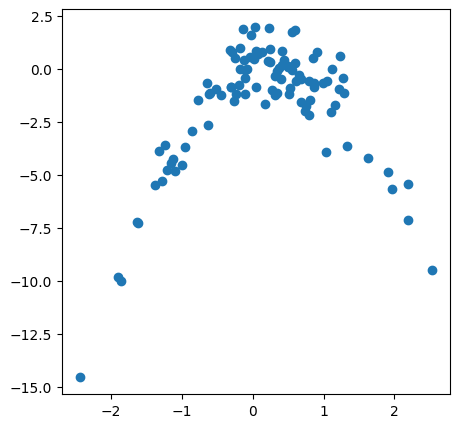

In [405]:
fig, ax = subplots(figsize=(5, 5))
ax.scatter(x, y);

The plot is an inverted parabola, very nonlinear.

**(c)** Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:

In [426]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)
df8 = pd.DataFrame({'X': x, 'Y': y, 'Intercept': np.ones((x.shape[0]))})
df8['X2'] = x**2
df8['X3'] = x**3
df8['X4'] = x**4

In [421]:
def linearMSE(data, X_select, Y_select):
    n = data.shape[0]
    sqErrTotal = 0

    for i in range(0,n):
        # Training
        data_i = data.drop(i, axis=0)
        X = data_i[X_select]
        y = data_i[Y_select]
        model = sm.OLS(y, X).fit()

        # Prediction
        model_pred = float( model.predict(exog=data.loc[[i], X_select]) ) # NOTE the brackets around the observation

        # Actual
        actual = data.loc[i, Y_select]

        # Error
        sqErr = (model_pred - actual)**2

        sqErrTotal += sqErr

    MSE = sqErrTotal/n
    print(f'CV MSE: {MSE:0.2f}')


- (i) $ Y = \beta_0 + \beta_1 X + \epsilon $

In [423]:
linearMSE(df8, ['Intercept', 'X'], 'Y')

CV MSE: 6.63


- (ii) $ Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon $

In [427]:
linearMSE(df8, ['Intercept', 'X', 'X2'], 'Y')

CV MSE: 1.12


- (iii) $ Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon $

In [428]:
linearMSE(df8, ['Intercept', 'X', 'X2', 'X3'], 'Y')

CV MSE: 1.30


- (iv) $ Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \beta_4 X^4 + \epsilon $

In [430]:
linearMSE(df8, ['Intercept', 'X', 'X2', 'X3', 'X4'], 'Y')

CV MSE: 1.33


**(d)** Repeat (c) using another random seed, and report your results. Are your results the same as what you got in (c)? Why?

In [431]:
rng = np.random.default_rng(2)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)
df8 = pd.DataFrame({'X': x, 'Y': y, 'Intercept': np.ones((x.shape[0]))})
df8['X2'] = x**2
df8['X3'] = x**3
df8['X4'] = x**4

linearMSE(df8, ['Intercept', 'X'], 'Y')
linearMSE(df8, ['Intercept', 'X', 'X2'], 'Y')
linearMSE(df8, ['Intercept', 'X', 'X2', 'X3'], 'Y')
linearMSE(df8, ['Intercept', 'X', 'X2', 'X3', 'X4'], 'Y')

CV MSE: 7.56
CV MSE: 0.98
CV MSE: 0.97
CV MSE: 0.97


Of course the results are different, because the data is different. Results are similar in that the second-order model performs imensely better than the first-order model, but improvements beyond second-order are negligible.

**(e)** Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

With the first seed, the second model (order 2) had the lowest LOOCV error. This was expected, as the data generating process was also second order.

**(f)** Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?

In [435]:
model = sm.OLS(df8['Y'], df8[['Intercept', 'X']]).fit()
summarize(model)

,coef,std err,t,P>|t|
Intercept,-1.8158,0.265,-6.857,0.0
X,1.1860,0.278,4.261,0.0


In [436]:
model = sm.OLS(df8['Y'], df8[['Intercept', 'X', 'X2']]).fit()
summarize(model)

,coef,std err,t,P>|t|
Intercept,-0.0572,0.121,-0.474,0.637
X,1.1121,0.103,10.791,0.000
X2,-1.9436,0.078,-24.870,0.000


In [437]:
model = sm.OLS(df8['Y'], df8[['Intercept', 'X', 'X2', 'X3']]).fit()
summarize(model)

,coef,std err,t,P>|t|
Intercept,-0.0402,0.121,-0.333,0.740
X,1.3206,0.178,7.426,0.000
X2,-1.9642,0.079,-24.850,0.000
X3,-0.0792,0.055,-1.435,0.155


In [438]:
model = sm.OLS(df8['Y'], df8[['Intercept', 'X', 'X2', 'X3', 'X4']]).fit()
summarize(model)

,coef,std err,t,P>|t|
Intercept,0.0238,0.144,0.166,0.869
X,1.3078,0.179,7.315,0.000
X2,-2.1290,0.214,-9.926,0.000
X3,-0.0690,0.057,-1.218,0.226
X4,0.0357,0.043,0.827,0.410


We note that the 1st and 2nd order terms are always significant, while the 3rd and 4th order terms are never significant. Seeing as the true model has a 1st and 2nd order term, and no 3rd or 4th order terms, this entirely makes sense. The model has correctly identified the true underlying data generating process.

This agrees with the LOOCV process which determines that the 1st and 2nd order terms are most relevant.

### 9

We will now consider the `Boston` housing data set, from the `ISLP` library.

In [446]:
Boston = load_data('Boston')
Boston.info()
Boston.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


**(a)** Based on this data set, provide an estimate for the population mean of `medv`. Call this estimate $ \hat{\mu} $.

In [449]:
mu = np.mean(Boston['medv'])
mu

22.532806324110677

**(b)** Provide an estimate of the standard error of $ \hat{\mu} $. Interpret this result.

*Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.*

In [452]:
np.std(Boston['medv'])/np.sqrt(Boston['medv'].shape[0])

0.4084569346972866

**(c)** Now estimate the standard error of $ \hat{\mu} $ using the bootstrap. How does this compare to your answer from (b)?

In [ ]:
rng = np.random.default_rng(0)

In [485]:
n = 1000
se_sum = 0

for _ in range(n):
    idx = rng.choice(Boston.index, Boston.shape[0], replace=True)
    se_sum += np.std(Boston['medv'][idx])/np.sqrt(Boston['medv'].shape[0])

se_boot = se_sum/n
se_boot

0.40758553604988923

The answer is close to (b).

**(d)** Based on your bootstrap estimate from (c), provide a 95 % confidence interval for the mean of `medv`. Compare it to the results obtained by using `Boston['medv'].std()` and the two standard error rule (3.9).

*Hint: You can approximate a 95 % confidence interval using the formula $ [ \hat{\mu} - 2 SE(\hat{\mu}), \hat{\mu} + 2 SE(\hat{\mu}) ] $ .*

In [492]:
# Bootstrap 95% confidence interval
low_b = mu - (2*se_boot)
high_b = mu + (2*se_boot)
print(f'Bootstrapped: [{low_b:0.2f}, {high_b:0.2f}]')

low_r = mu - (2*Boston['medv'].std()/np.sqrt(Boston.shape[0]))
high_r = mu + (2*Boston['medv'].std()/np.sqrt(Boston.shape[0]))
print(f'Two-SE Rule: [{low_r:0.2f}, {high_r:0.2f}]')


Bootstrapped: [21.72, 23.35]
Two-SE Rule: [21.72, 23.35]


The results are nearly identical.

**(e)** Based on this data set, provide an estimate, $\hat{\mu}_{med}$, for the median value of `medv` in the population.

In [493]:
Boston['medv'].median()

21.2

**(f)** We now would like to estimate the standard error of $\hat{\mu}_{med}$. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.

In [505]:
n = 1000
med_samples = np.empty(n)

for i in range(n):
    idx = rng.choice(Boston.index, Boston.shape[0], replace=True)
    med_samples[i] = Boston['medv'][idx].median()



In [508]:
med_samples.std()

0.3876268695536982

The estimated s.e. for the median is 0.38, slightly smaller than that of the mean. This makes sense: we would expect for the median to have less variance because it the measure eliminates the influence out outliers.

**(g)** Based on this data set, provide an estimate for the tenth percentile of `medv` in `Boston` census tracts. Call this quantity $\hat{\mu}_{0.1}$. (You can use the `np.percentile()` function.)

In [522]:
mu_01 = np.percentile(Boston['medv'], 10)
mu_01

12.75

**(h)** Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$. Comment on your findings.

In [524]:
n = 1000
tenthpc_samples = np.empty(n)

for i in range(n):
    idx = rng.choice(Boston.index, Boston.shape[0], replace=True)
    tenthpc_samples[i] = np.percentile(Boston['medv'][idx], 10)

tenthpc_samples.std()

0.49058026866151067

In [528]:
# botlnec.github.io
medv = Boston['medv']
quantiles = [medv.sample(n = len(medv), replace=True).quantile(.1) for _ in range(1000)]
np.std(quantiles)

0.4930403127534299

The s.e. for the 10th percentile is actually higher than that of the median. This could be because it is more easily influenced by extreme observations in the lower tail.